# Joe's cool code

In [1]:
# Import General Libs
import pandas as pd
import os
import scipy as sp
from scipy import integrate
from scipy import diff
import numpy as np

# Import project libs
import Data.DataWrangle as DW

In [2]:
#Data setup
cleanData = DW.read_into_MC_format(with_pct_change=True)
# cleanData

In [3]:
# def add_Rolling_ID_Values(df:pd.DataFrame,data_col,rollNum):
#     result = add_rolling_integrate(df,data_col,rollNum)
#     result = add_rolling_derivatives(result,data_col,rollNum)
#     return result
def add_rolling_integrate(df:pd.DataFrame,data_col,rollNum):
    data = df[data_col]
    integral = data.rolling(rollNum).apply(integrate.trapz)
    integral = integral.rename(f'{data_col}_integral')
    return pd.concat([df,integral],axis=1)

# def add_rolling_derivatives(df:pd.DataFrame,data_col,rollNum):
#     data = df[data_col]
#     derivative = data.rolling(rollNum).apply(diff)
#     derivative = derivative.rename(f'{data_col}_derivative')
#     return pd.concat([df,derivative],axis=1)

In [4]:
window = 30
VIX_PID_Data = add_rolling_integrate(cleanData['VIX'],'close',window)
VIX_PID_Data = add_rolling_integrate(VIX_PID_Data,'pct_change',window)
VIX_PID_Data = DW.tag_columns(VIX_PID_Data,'VIX')
# VIX_PID_Data.dropna()

In [5]:
SPY_PID_Data = add_rolling_integrate(cleanData['SPY'],'close',window)
SPY_PID_Data = add_rolling_integrate(SPY_PID_Data,'pct_change',window)
SPY_PID_Data = DW.tag_columns(SPY_PID_Data,'SPY')
# SPY_PID_Data

In [6]:
graphing_data = pd.concat([VIX_PID_Data,SPY_PID_Data],axis=1)
graphing_data


,VIX_close,VIX_pct_change,VIX_close_integral,VIX_pct_change_integral,SPY_close,SPY_pct_change,SPY_close_integral,SPY_pct_change_integral
timestamp,,,,,,,,
1990-01-02,17.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03,18.19,0.055104,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04,19.22,0.056625,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05,20.11,0.046306,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08,20.26,0.007459,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2022-03-24,21.67,-0.080611,831.600,0.121465,450.48,0.015052,12593.880,-0.010668
2022-03-25,20.81,-0.039686,827.205,-0.109777,452.69,0.004906,12600.575,0.018153
2022-03-28,19.63,-0.056704,819.580,-0.247844,455.91,0.007113,12615.135,0.035656


<AxesSubplot:xlabel='timestamp'>

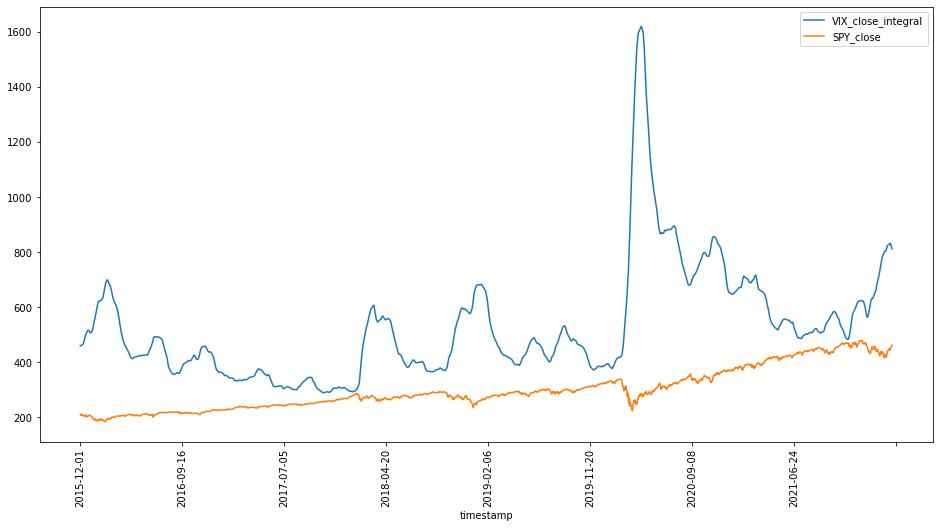

In [7]:
scaled = graphing_data
# scaled['VIX_close_integral'] = graphing_data['VIX_close_integral']+graphing_data['SPY_close'].dropna().iloc[0]
scaled[['VIX_close_integral','SPY_close']].dropna().plot(rot=90,figsize=(16,8))

<AxesSubplot:xlabel='timestamp'>

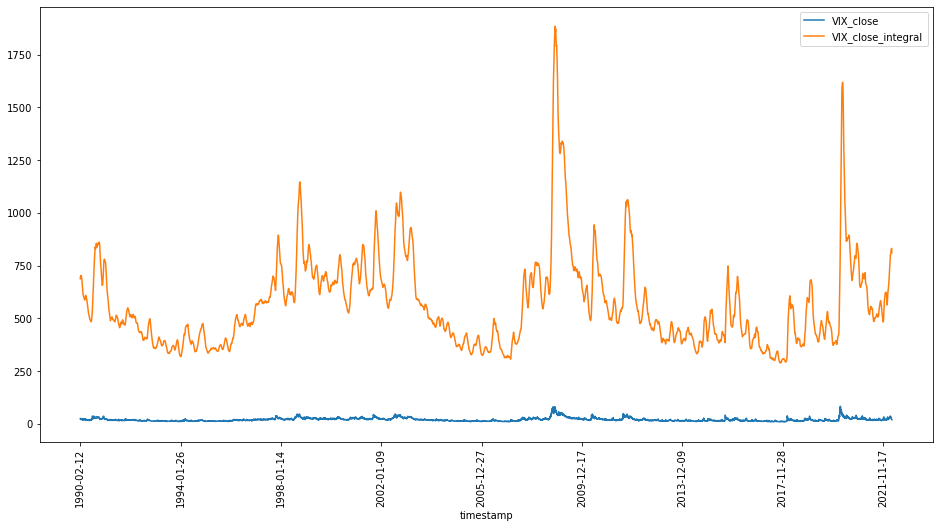

In [8]:
scaled = graphing_data
# scaled['VIX_close_integral'] = graphing_data['VIX_close_integral']+graphing_data['SPY_close'].dropna().iloc[0]
scaled[['VIX_close','VIX_close_integral']].dropna().plot(rot=90,figsize=(16,8))